In [1]:
# TODO: Add the spectrum estimation of the parameters of the graphs

%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append('../..')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from IPython.display import display

from pyvis.network import Network

import pickle
import os

import math
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [3]:
# ------------------------
# Functions
# ------------------------

def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL'):
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)
   
   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
   graphs, spec, spectrum_diffs, best_iteration = graph_model.populate_edges_spectrum(
       warm_up=warm_up,
       max_iterations=n_iteration,
       patience=patience,  # You may want to adjust this value
       real_graph=real_graph
   )

   # Add early stopping condition
   if len(spectrum_diffs) > 10000 and all(abs(spectrum_diffs[-1] - sd) < 1e-6 for sd in spectrum_diffs[-10000:]):
       print("Early stopping: No significant improvement in the last 1000 iterations.")
       best_iteration = len(spectrum_diffs) - 10000

   # Use the best graph found
   best_graph = graphs[best_iteration]
   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type # KL or L1 or L2
   ).calculate_gic()
   
   gic_values = [gic_value]
   return best_graph, sigma, gic_values, spectrum_diffs, best_iteration, graphs

def clean_and_convert(param):
    cleaned_param = ''.join(c for c in param if c.isdigit() or c == '.' or c == '-')
    return float(cleaned_param)

def plot_graphs_in_matrix(sim_graphs_dict, result_dict, global_title, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Use force-directed layout for better distribution of nodes
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Normalize node sizes and reduce
        degrees = dict(G.degree())
        max_degree = max(degrees.values())
        min_degree = min(degrees.values())
        node_sizes = [((degrees[node] - min_degree) / (max_degree - min_degree + 1e-6)) * 100 + 10 for node in G.nodes()]

        # Normalize node colors
        node_color = list(degrees.values())

        # Draw edges first
        edge_color = 'lightgray'
        alpha = 1
        width = 0.8
        if G.number_of_edges() > 1000:
            # For dense graphs, sample a subset of edges
            edges = list(G.edges())
            sampled_edges = np.random.choice(len(edges), size=1000, replace=False)
            edges = [edges[i] for i in sampled_edges]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color, alpha=alpha, width=width, ax=ax)
        else:
            nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=alpha, width=width, ax=ax)

        # Draw nodes on top of edges
        scatter = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, 
                                         cmap=plt.cm.viridis, ax=ax, alpha=0.8)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph\nGIC: {result_dict[name]["GIC"]:.2f}', fontsize=10)
        else:
            ax.set_title(f'{name} Graph', fontsize=10)
        ax.axis('off')

        # Add a colorbar to show degree scale
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label('Node Degree', fontsize=8)
        cbar.ax.tick_params(labelsize=6)

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig

def plot_spectra_in_matrix(sim_graphs_dict, result_dict, global_title, bins=120, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Calculate the spectrum (eigenvalues) of the graph
        laplacian = nx.normalized_laplacian_matrix(G)
        eigenvalues = np.linalg.eigvals(laplacian.toarray())
        eigenvalues = np.real(eigenvalues)  # Take only the real part

        # Plot histogram of eigenvalues
        ax.hist(eigenvalues, bins=bins, density=True, alpha=0.7, color='skyblue')

        # Calculate and plot KDE
        kde = stats.gaussian_kde(eigenvalues)
        x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
        ax.plot(x_range, kde(x_range), 'r-', lw=2)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph Spectrum\nGIC: {result_dict[name]["GIC"]:.2f}', fontsize=15)
        else:
            ax.set_title(f'{name} Graph Spectrum', fontsize=15)
        ax.set_xlabel('Eigenvalue', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=10)

        # Add text with graph properties
        props = f"Nodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}"
        ax.text(0.95, 0.95, props, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=20, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig


In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
from scipy import stats
import warnings

# Define a function to compute several features of a graph.
def compute_features(G):
    features = {}
    
    # Basic graph properties
    features['num_nodes'] = G.number_of_nodes()
    features['num_edges'] = G.number_of_edges()
    features['density'] = nx.density(G)
    features['is_connected'] = int(nx.is_connected(G))
    features['num_connected_components'] = nx.number_connected_components(G)
    
    # Degree-related features
    degrees = np.array(list(dict(G.degree()).values()))
    features['avg_degree'] = float(degrees.mean())
    features['median_degree'] = float(np.median(degrees))
    features['min_degree'] = float(degrees.min())
    features['max_degree'] = float(degrees.max())
    features['degree_variance'] = float(degrees.var())
    features['degree_skewness'] = float(stats.skew(degrees))
    features['degree_kurtosis'] = float(stats.kurtosis(degrees))
    
    # Clustering and transitivity
    features['avg_clustering'] = nx.average_clustering(G)
    features['transitivity'] = nx.transitivity(G)
    
    # Path-related features
    if nx.is_connected(G):
        # Only compute for smaller graphs to avoid slow calculations
        if G.number_of_nodes() < 1000:
            features['avg_shortest_path'] = nx.average_shortest_path_length(G)
            features['diameter'] = nx.diameter(G)
            features['radius'] = nx.radius(G)
        else:
            features['avg_shortest_path'] = float('nan')
            features['diameter'] = float('nan')
            features['radius'] = float('nan')
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        subG = G.subgraph(largest_cc)
        if subG.number_of_nodes() < 1000:
            features['avg_shortest_path'] = nx.average_shortest_path_length(subG)
            features['diameter'] = nx.diameter(subG)
            features['radius'] = nx.radius(subG)
        else:
            features['avg_shortest_path'] = float('nan')
            features['diameter'] = float('nan')
            features['radius'] = float('nan')
    
    # Spectral properties
    # Laplacian spectrum
    L = nx.laplacian_matrix(G).todense()
    eigenvalues = np.sort(np.linalg.eigvalsh(L))
    features['spectral_gap'] = float(eigenvalues[1]) if len(eigenvalues) > 1 else 0.0
    features['laplacian_energy'] = float(np.sum(np.abs(eigenvalues)))
    
    # Adjacency spectrum
    A = nx.adjacency_matrix(G).todense()
    adj_eigenvalues = np.sort(np.linalg.eigvalsh(A))[::-1]  # Sort in descending order
    features['spectral_radius'] = float(adj_eigenvalues[0])
    features['energy'] = float(np.sum(np.abs(adj_eigenvalues)))
    
    # Algebraic connectivity (Fiedler value)
    features['algebraic_connectivity'] = float(eigenvalues[1]) if len(eigenvalues) > 1 else 0.0
    
    # Community structure - only for smaller graphs
    if G.number_of_nodes() < 1000:
        try:
            communities = nx.community.greedy_modularity_communities(G)
            features['num_communities'] = len(communities)
            features['modularity'] = nx.community.modularity(G, communities)
            community_sizes = [len(c) for c in communities]
            features['community_size_mean'] = float(np.mean(community_sizes))
            features['community_size_std'] = float(np.std(community_sizes))
        except:
            features['num_communities'] = float('nan')
            features['modularity'] = float('nan')
            features['community_size_mean'] = float('nan')
            features['community_size_std'] = float('nan')
    else:
        features['num_communities'] = float('nan')
        features['modularity'] = float('nan')
        features['community_size_mean'] = float('nan')
        features['community_size_std'] = float('nan')
    
    # Structural properties
    features['avg_neighbor_degree'] = float(np.mean(list(nx.average_neighbor_degree(G).values())))
    
    # Triangle count and related metrics
    triangles = nx.triangles(G)
    features['triangle_count_total'] = sum(triangles.values()) // 3
    features['triangle_count_mean'] = float(np.mean(list(triangles.values())))
    
    # Degree assortativity - can be slow for large graphs but usually acceptable
    try:
        features['degree_assortativity'] = nx.degree_assortativity_coefficient(G)
    except:
        features['degree_assortativity'] = float('nan')
    
    return features

In [7]:
np.random.seed(42)
datasets = f'../../data/connectomes/'
#already_done = os.listdir('../images/imgs_connectomes/') 
#excluded = ['c.elegans.herm_pharynx_1.graphml']
#already_done = [os.path.splitext(file)[0] for file in already_done] + excluded

connectomes = sorted(os.listdir(datasets)) 
#connectomes = [connectome for connectome in connectomes if connectome not in already_done]
print(connectomes)
connectome_file = connectomes[0]
connectome_file = 'rhesus_cerebral.cortex_1.graphml'

['.DS_Store', 'c.elegans.herm_pharynx_1.graphml', 'c.elegans_neural.male_1.graphml', 'drosophila_medulla_1.graphml', 'kasthuri_graph_v4.graphml', 'mixed.species_brain_1.graphml', 'mouse_brain_1.graphml', 'mouse_retina_1.graphml', 'mouse_visual.cortex_1.graphml', 'mouse_visual.cortex_2.graphml', 'p.pacificus_neural.synaptic_1.graphml', 'p.pacificus_neural.synaptic_2.graphml', 'rattus.norvegicus_brain_1.graphml', 'rattus.norvegicus_brain_2.graphml', 'rattus.norvegicus_brain_3.graphml', 'rhesus_brain_1.graphml', 'rhesus_brain_2.graphml', 'rhesus_cerebral.cortex_1.graphml', 'rhesus_interareal.cortical.network_2.graphml']


In [8]:
# ------------------------
# Simulation settings
# ------------------------

# Number of simulations per model (can be increased if desired)
n_sim = 50

# Prepare a list to store the feature dictionaries of each simulation.
simulations = []

real_G = nx.read_graphml(os.path.join(datasets, connectome_file))
real_G = nx.from_numpy_array(nx.to_numpy_array(real_G))

# Compute and store the features of the real graph.
real_features = compute_features(real_G)
real_features['model'] = 'Real'
real_features['sim'] = 0  # simulation index (0 for the real graph)
simulations.append(real_features)

In [9]:
# ------------------------
# basic parameters based on the real graph.
# TODO: Improve this part of the code
# ------------------------
n = real_G.number_of_nodes()
avg_deg = float(np.mean(list(dict(real_G.degree()).values())))
p_er = avg_deg / (n - 1) if n > 1 else 0.0            # for ER
k_ws = max(2, int(round(avg_deg)))                    # for WS (k is the number of neighbors)
m_ba = max(1, int(round(avg_deg / 2)))                # for BA (m is the number of edges to attach)
k_reg = max(2, int(round(avg_deg)))                    # for K-regular (k is the degree)
theta = 0.5


In [10]:
# ------------------------
# Simulate graphs from different models and compute their features.
# ------------------------

# ER simulations
for i in range(n_sim):
    sim_graph = nx.erdos_renyi_graph(n=n, p=p_er)
    feat = compute_features(sim_graph)
    feat['model'] = 'ER'
    feat['sim'] = i
    simulations.append(feat)
    print(f'Computed features for ER graph {i}')
 

Computed features for ER graph 0
Computed features for ER graph 1
Computed features for ER graph 2
Computed features for ER graph 3
Computed features for ER graph 4
Computed features for ER graph 5
Computed features for ER graph 6
Computed features for ER graph 7
Computed features for ER graph 8
Computed features for ER graph 9
Computed features for ER graph 10
Computed features for ER graph 11
Computed features for ER graph 12
Computed features for ER graph 13
Computed features for ER graph 14
Computed features for ER graph 15
Computed features for ER graph 16
Computed features for ER graph 17
Computed features for ER graph 18
Computed features for ER graph 19
Computed features for ER graph 20
Computed features for ER graph 21
Computed features for ER graph 22
Computed features for ER graph 23
Computed features for ER graph 24
Computed features for ER graph 25
Computed features for ER graph 26
Computed features for ER graph 27
Computed features for ER graph 28
Computed features for ER

In [12]:
# K-regular simulations
for i in range(n_sim):
    sim_graph = nx.random_regular_graph(d=k_reg-1, n=n)
    feat = compute_features(sim_graph)
    feat['model'] = 'K-regular'
    feat['sim'] = i
    simulations.append(feat)
    print(f'Computed features for K-regular graph {i}')


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_8770/3750811359.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['degree_skewness'] = float(stats.skew(degrees))
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_8770/3750811359.py:27: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['degree_kurtosis'] = float(stats.kurtosis(degrees))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


Computed features for K-regular graph 0
Computed features for K-regular graph 1
Computed features for K-regular graph 2
Computed features for K-regular graph 3
Computed features for K-regular graph 4
Computed features for K-regular graph 5
Computed features for K-regular graph 6
Computed features for K-regular graph 7
Computed features for K-regular graph 8
Computed features for K-regular graph 9
Computed features for K-regular graph 10
Computed features for K-regular graph 11
Computed features for K-regular graph 12
Computed features for K-regular graph 13
Computed features for K-regular graph 14
Computed features for K-regular graph 15
Computed features for K-regular graph 16
Computed features for K-regular graph 17
Computed features for K-regular graph 18
Computed features for K-regular graph 19
Computed features for K-regular graph 20
Computed features for K-regular graph 21
Computed features for K-regular graph 22
Computed features for K-regular graph 23
Computed features for K-re

In [13]:
# RGG (Random Geometric Graph) simulations 
for i in range(n_sim):
    sim_graph = nx.random_geometric_graph(n=n, radius=theta)
    feat = compute_features(sim_graph)
    feat['model'] = 'RGG'
    feat['sim'] = i
    simulations.append(feat)
    print(f'Computed features for RGG graph {i}')


Computed features for RGG graph 0
Computed features for RGG graph 1
Computed features for RGG graph 2
Computed features for RGG graph 3
Computed features for RGG graph 4
Computed features for RGG graph 5
Computed features for RGG graph 6
Computed features for RGG graph 7
Computed features for RGG graph 8
Computed features for RGG graph 9
Computed features for RGG graph 10
Computed features for RGG graph 11
Computed features for RGG graph 12
Computed features for RGG graph 13
Computed features for RGG graph 14
Computed features for RGG graph 15
Computed features for RGG graph 16
Computed features for RGG graph 17
Computed features for RGG graph 18
Computed features for RGG graph 19
Computed features for RGG graph 20
Computed features for RGG graph 21
Computed features for RGG graph 22
Computed features for RGG graph 23
Computed features for RGG graph 24
Computed features for RGG graph 25
Computed features for RGG graph 26
Computed features for RGG graph 27
Computed features for RGG grap

In [14]:
# WS simulations (Watts-Strogatz)
for i in range(n_sim):
    sim_graph = nx.watts_strogatz_graph(n=n, k=k_ws, p=p_er)
    feat = compute_features(sim_graph)
    feat['model'] = 'WS'
    feat['sim'] = i
    simulations.append(feat)
    print(f'Computed features for WS graph {i}')
 

Computed features for WS graph 0
Computed features for WS graph 1
Computed features for WS graph 2
Computed features for WS graph 3
Computed features for WS graph 4
Computed features for WS graph 5
Computed features for WS graph 6
Computed features for WS graph 7
Computed features for WS graph 8
Computed features for WS graph 9
Computed features for WS graph 10
Computed features for WS graph 11
Computed features for WS graph 12
Computed features for WS graph 13
Computed features for WS graph 14
Computed features for WS graph 15
Computed features for WS graph 16
Computed features for WS graph 17
Computed features for WS graph 18
Computed features for WS graph 19
Computed features for WS graph 20
Computed features for WS graph 21
Computed features for WS graph 22
Computed features for WS graph 23
Computed features for WS graph 24
Computed features for WS graph 25
Computed features for WS graph 26
Computed features for WS graph 27
Computed features for WS graph 28
Computed features for WS

In [15]:
# BA simulations (Barabási-Albert)
for i in range(n_sim):
    sim_graph = nx.barabasi_albert_graph(n=n, m=m_ba)
    feat = compute_features(sim_graph)
    feat['model'] = 'BA'
    feat['sim'] = i
    simulations.append(feat)



In [16]:
# LG simulations (Logit Graph model).
N_ITERATION = 5000
WARM_UP = 5000
D = 0
PATIENCE = 5
DIST_TYPE = 'KL'

for i in range(10):
    try:
        lg_graph_array, sigma, gic_values, spectrum_diffs, best_iteration, graphs = get_logit_graph(
            real_graph=real_G,
            d=D,
            n_iteration=N_ITERATION,
            warm_up=WARM_UP,
            patience=PATIENCE,
            dist_type=DIST_TYPE
        )
        lg_G = nx.from_numpy_array(lg_graph_array)
        feat = compute_features(lg_G)
        feat['model'] = 'LG'
        feat['sim'] = i
        simulations.append(feat)
    except Exception as e:
        print(f"Error in LG simulation {i}: {e}")



iteration: 0
	 Spectrum difference: 418.0243677907997
iteration: 1000
	 Spectrum difference: 284.34091868930915
iteration: 2000
	 Spectrum difference: 241.9747016206666
iteration: 3000
	 Spectrum difference: 266.76147652837955
iteration: 4000
	 Spectrum difference: 312.7806155786607
	 Best iteration: 2083
	 Best spectrum difference: 239.46293502282654
	 Number of edges: 5912.0, Number of edges real graph: 3436.0
iteration: 0
	 Spectrum difference: 417.49187056846114
iteration: 1000
	 Spectrum difference: 286.76501348364906
iteration: 2000
	 Spectrum difference: 241.33667631259573
iteration: 3000
	 Spectrum difference: 259.473293015505
iteration: 4000
	 Spectrum difference: 305.44430340893257
	 Best iteration: 2235
	 Best spectrum difference: 240.23645062684704
	 Number of edges: 5798.0, Number of edges real graph: 3436.0
iteration: 0
	 Spectrum difference: 412.62753340469555
iteration: 1000
	 Spectrum difference: 279.42826795236437
iteration: 2000
	 Spectrum difference: 235.59468833829

# Saving simulations

In [17]:
import pickle
folder = f'runs/features_pca_analysis_{connectome_file}'
os.makedirs(folder, exist_ok=True)
with open(os.path.join(folder, 'simulations.pkl'), 'wb') as f:
    pickle.dump(simulations, f)

In [ ]:
# # Load the simulations from a file
# with open(os.path.join(folder, 'simulations.pkl'), 'rb') as f:
#     simulations = pickle.load(f)

In [ ]:

# # Load the simulations from a file
# with open(os.path.join(folder, 'simulations.pkl'), 'rb') as f:
#     simulations = pickle.load(f)

# Analysis

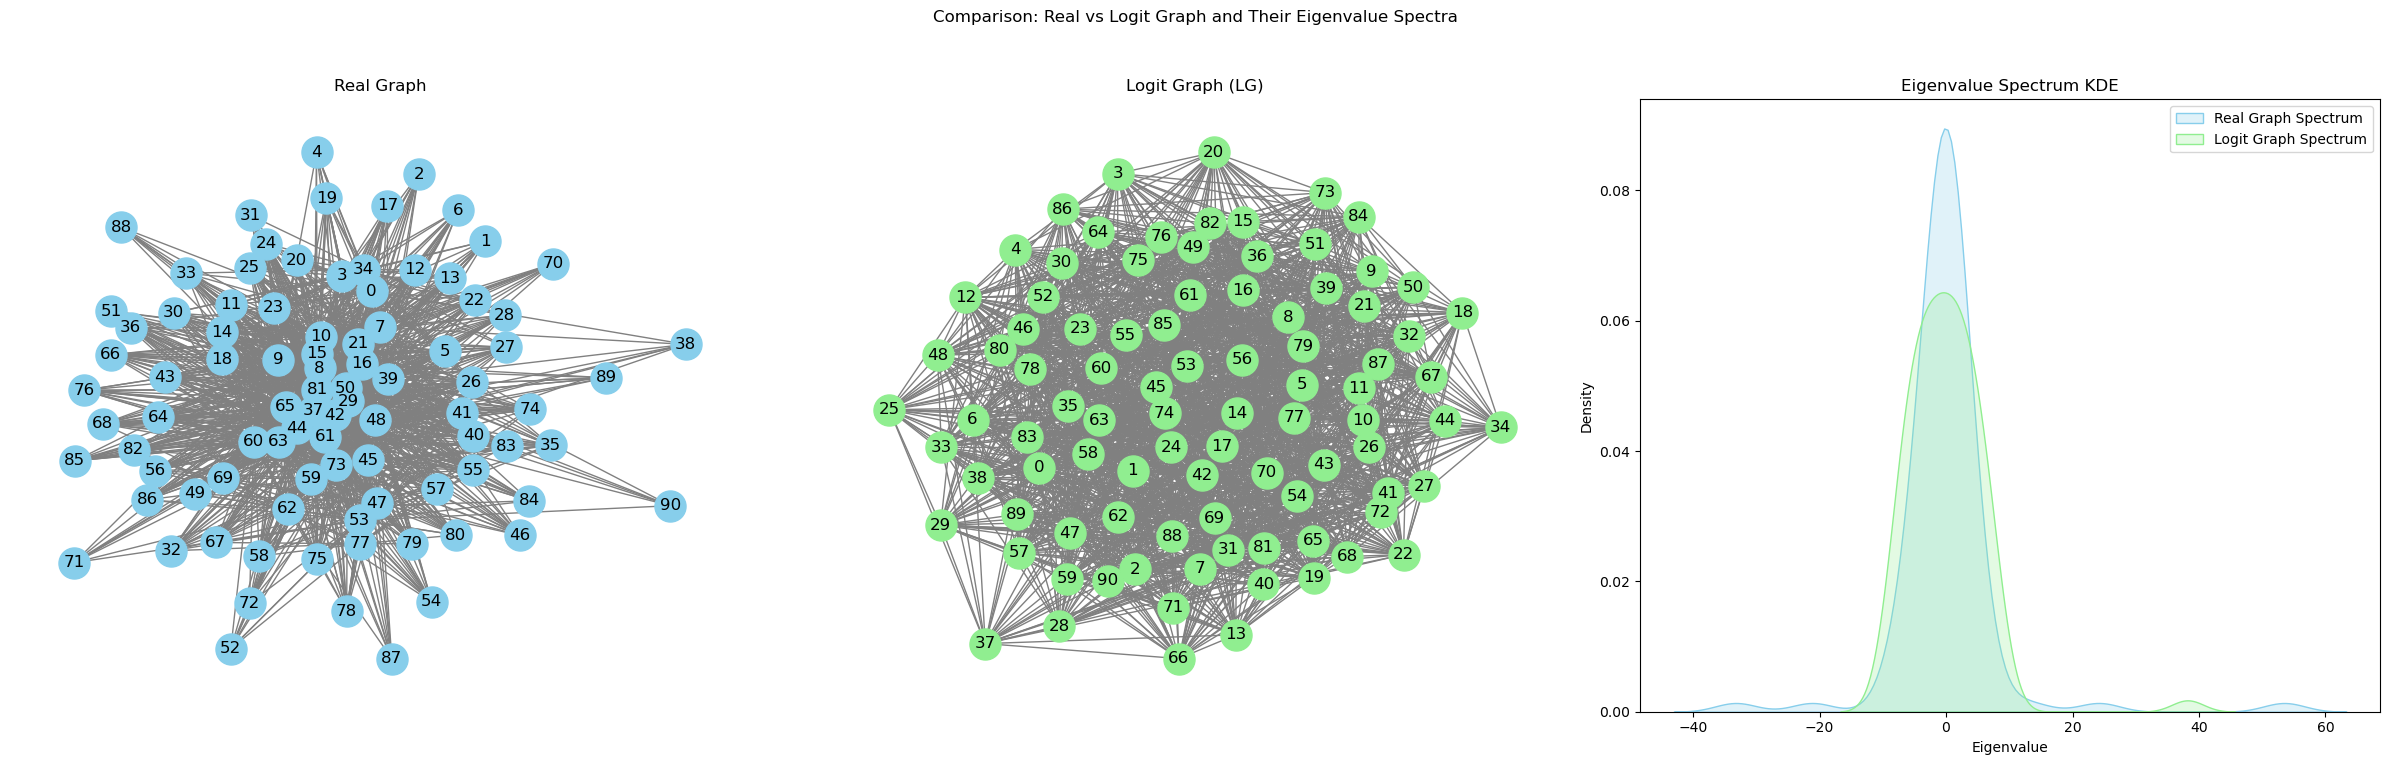

In [18]:
# Plot a visualization to compare the real graph and a logit graph, and add their eigenvalue spectrum with a KDE estimation.
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot the real graph in the left subplot
pos_real = nx.spring_layout(real_G)
nx.draw(real_G, pos_real, ax=axes[0],
        node_color='skyblue',
        edge_color='gray',
        with_labels=True,
        node_size=500)
axes[0].set_title('Real Graph')

# Plot the logit graph (LG) in the middle subplot
pos_lg = nx.spring_layout(lg_G)
nx.draw(lg_G, pos_lg, ax=axes[1],
        node_color='lightgreen',
        edge_color='gray',
        with_labels=True,
        node_size=500)
axes[1].set_title('Logit Graph (LG)')

# Plot the spectrum with KDE estimation in the right subplot.
# Compute the eigenvalue spectrum for both graphs using the adjacency matrix.
real_eig = nx.adjacency_spectrum(real_G).real
lg_eig = nx.adjacency_spectrum(lg_G).real

# Plot the kernel density estimate for each spectrum.
sns.kdeplot(real_eig, ax=axes[2], label='Real Graph Spectrum', fill=True, color='skyblue')
sns.kdeplot(lg_eig, ax=axes[2], label='Logit Graph Spectrum', fill=True, color='lightgreen')
axes[2].set_title('Eigenvalue Spectrum KDE')
axes[2].set_xlabel('Eigenvalue')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.suptitle('Comparison: Real vs Logit Graph and Their Eigenvalue Spectra')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [19]:
df_features = pd.DataFrame(simulations)

In [20]:
from datetime import datetime
import random

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
random_suffix = random.randint(1000000, 9999999)  # Use random module instead of hash
filename = f'{folder}/features_pca_analysis_{connectome_file}_{random_suffix}.parquet'

print(filename)
df_features.to_parquet(filename)
df_features.head()

runs/features_pca_analysis_rhesus_cerebral.cortex_1.graphml/features_pca_analysis_rhesus_cerebral.cortex_1.graphml_7711096.parquet


,num_nodes,num_edges,density,is_connected,num_connected_components,avg_degree,median_degree,min_degree,max_degree,degree_variance,...,num_communities,modularity,community_size_mean,community_size_std,avg_neighbor_degree,triangle_count_total,triangle_count_mean,degree_assortativity,model,sim
0,91,1401,0.342125,1,1,30.791209,20.0,6.0,87.0,458.714648,...,3,0.149503,30.333333,17.461068,54.399834,10336,340.747253,-0.553435,Real,0
1,91,1423,0.347497,1,1,31.274725,31.0,22.0,41.0,18.243207,...,3,0.105654,30.333333,5.185450,31.882542,5081,167.505495,-0.041977,ER,0
2,91,1392,0.339927,1,1,30.593407,30.0,19.0,43.0,20.131385,...,3,0.099785,30.333333,6.018490,31.258572,4749,156.560440,-0.007848,ER,1
3,91,1398,0.341392,1,1,30.725275,30.0,18.0,45.0,24.397053,...,3,0.104338,30.333333,0.471405,31.527125,4906,161.736264,-0.012096,ER,2
4,91,1434,0.350183,1,1,31.516484,32.0,21.0,47.0,21.612366,...,4,0.100472,22.750000,11.605494,32.220486,5214,171.890110,-0.024711,ER,3


In [21]:
feature_columns = ['num_nodes', 'num_edges', 'density', 'is_connected', 'num_connected_components', 
                  'avg_degree', 'median_degree', 'min_degree', 'max_degree', 'degree_variance',
                  'degree_skewness', 'degree_kurtosis', 'avg_clustering', 'transitivity',
                  'avg_shortest_path', 'diameter', 'radius', 'spectral_gap', 'algebraic_connectivity',
                  'num_communities', 'modularity', 'community_size_mean', 'community_size_std',
                  'avg_neighbor_degree', 'triangle_count_total', 'triangle_count_mean', 'degree_assortativity']

In [22]:
df_features[feature_columns].head()

,num_nodes,num_edges,density,is_connected,num_connected_components,avg_degree,median_degree,min_degree,max_degree,degree_variance,...,spectral_gap,algebraic_connectivity,num_communities,modularity,community_size_mean,community_size_std,avg_neighbor_degree,triangle_count_total,triangle_count_mean,degree_assortativity
0,91,1401,0.342125,1,1,30.791209,20.0,6.0,87.0,458.714648,...,5.960142,5.960142,3,0.149503,30.333333,17.461068,54.399834,10336,340.747253,-0.553435
1,91,1423,0.347497,1,1,31.274725,31.0,22.0,41.0,18.243207,...,20.162397,20.162397,3,0.105654,30.333333,5.185450,31.882542,5081,167.505495,-0.041977
2,91,1392,0.339927,1,1,30.593407,30.0,19.0,43.0,20.131385,...,18.000237,18.000237,3,0.099785,30.333333,6.018490,31.258572,4749,156.560440,-0.007848
3,91,1398,0.341392,1,1,30.725275,30.0,18.0,45.0,24.397053,...,17.041303,17.041303,3,0.104338,30.333333,0.471405,31.527125,4906,161.736264,-0.012096
4,91,1434,0.350183,1,1,31.516484,32.0,21.0,47.0,21.612366,...,19.312715,19.312715,4,0.100472,22.750000,11.605494,32.220486,5214,171.890110,-0.024711


In [36]:
connectome_file_name = connectome_file.replace('.graphml', '')
connectome_file_name 

'rhesus_cerebral.cortex_1'

## PCA

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def perform_pca_analysis(df_features, feature_columns, n_components=2):
    """
    Perform PCA analysis on graph features
    
    Parameters:
    -----------
    df_features : pandas DataFrame
        DataFrame containing features and model information
    feature_columns : list
        List of column names to use as features
    n_components : int, default=2
        Number of PCA components to extract
        
    Returns:
    --------
    X_raw : pandas DataFrame
        Original dataframe with PCA components added
    explained_variance : numpy array
        Explained variance ratio for each component
    """
    # Remove the RGG model if it exists
    X_raw = df_features[df_features['model'] != 'RGG'] if 'RGG' in df_features['model'].unique() else df_features
    
    # Get feature columns
    X = X_raw[feature_columns].copy()
    X = X.fillna(X.mean())
    
    # Standardize the features before applying PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)
    
    # Apply PCA to reduce the dimensionality
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Add PCA components to the original dataframe
    X_raw = X_raw.copy()
    for i in range(n_components):
        X_raw[f'PC{i+1}'] = X_pca[:, i]
    
    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    
    return X_raw, explained_variance


X_raw, explained_variance = perform_pca_analysis(df_features, feature_columns)

In [38]:
def plot_dim_red_results(X_raw, explained_variance, graph_name="graph", figsize=(12, 10)):
    """
    Create a publication-quality PCA plot
    
    Parameters:
    -----------
    X_raw : pandas DataFrame
        DataFrame with PCA components and model information
    explained_variance : numpy array
        Explained variance ratio for each component
    graph_name : str, default="graph"
        Name of the graph to display in the title
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    # Create a color palette mapping with distinct colors
    palette = sns.color_palette("colorblind")
    model_types = X_raw['model'].unique()
    color_dict = {model: palette[i % len(palette)] for i, model in enumerate(model_types)}
    
    # Define markers for different model types
    markers = {'Real': 'X', 'ER': 'o', 'K-regular': 'P', 'WS': 'D', 'BA': '^', 'LG': 's'}
    model_markers = {model: markers.get(model, 'o') for model in model_types}
    
    # Plot density contours for each model family
    for model in model_types:
        if model == 'Real':  # Skip density for real graph
            continue
        subset = X_raw[X_raw['model'] == model]
        if len(subset) > 1:  # Only plot KDE if we have multiple points
            try:
                sns.kdeplot(
                    x=subset['PC1'], y=subset['PC2'],
                    color=color_dict[model],
                    levels=3, linewidths=1, alpha=0.3,
                    ax=ax
                )
            except Exception:
                # If KDE fails, just continue without the density plot
                pass
    
    # Scatter plot with enhanced aesthetics
    scatter = sns.scatterplot(
        data=X_raw, x='PC1', y='PC2',
        hue='model', style='model',
        s=100, edgecolor='white', linewidth=0.5,
        palette=color_dict, alpha=0.9, ax=ax,
        legend='full',
        markers=model_markers
    )
    
    # Highlight the real graph
    real_data = X_raw[X_raw['model'] == 'Real']
    if not real_data.empty:
        for _, row in real_data.iterrows():
            plt.scatter(row['PC1'], row['PC2'], s=200, facecolors='none', edgecolors='black', linewidth=2, zorder=10)
            plt.text(row['PC1'], row['PC2'] - 0.5, 'Real', fontsize=14, weight='bold', 
                    color='black', ha='center', va='top',
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    # Add plot decorations
    plt.title(f'PCA of Graph Features: {graph_name}', fontsize=16)
    plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance explained)', fontsize=12)
    plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance explained)', fontsize=12)
    plt.grid(True, alpha=0.2, linestyle='--')
    
    # Create legend with better positioning
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles, labels,
        title='Model Type', 
        title_fontsize=12,
        fontsize=10,
        loc='upper right',
        frameon=True,
        framealpha=0.9,
        edgecolor='gray'
    )
    
    plt.tight_layout()
    return plt

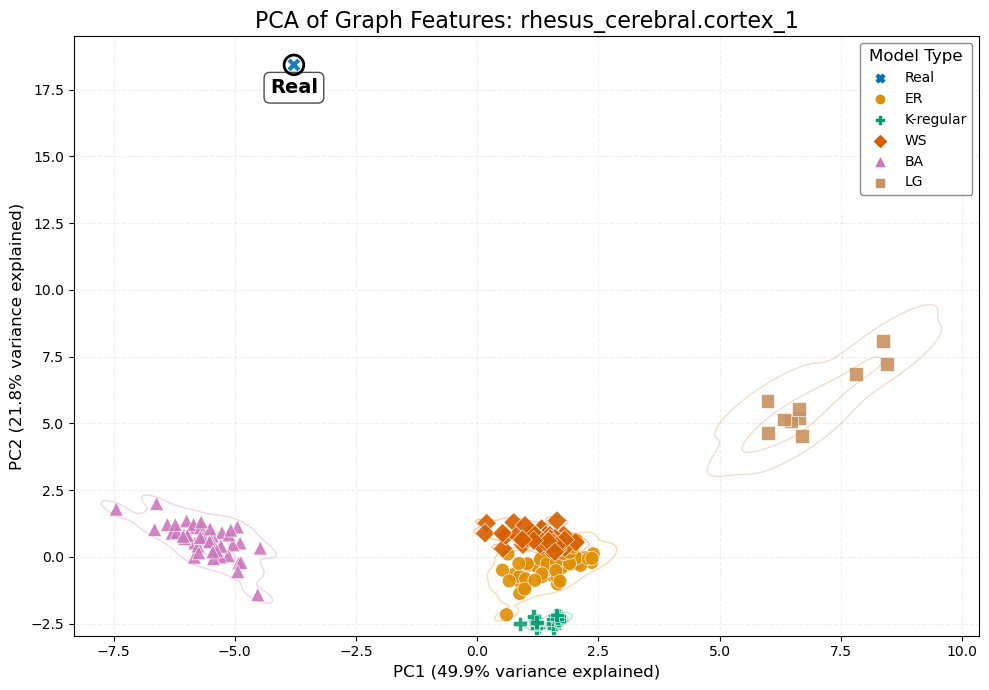

In [40]:
plot = plot_dim_red_results(X_raw, explained_variance, connectome_file_name, figsize=(10, 7))
os.makedirs(f'imgs', exist_ok=True)
plot.savefig(f'imgs/{connectome_file_name}_pca_plot.png', dpi=100, bbox_inches='tight')
plot.show()

## Multidimensional scaling

In [41]:
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler

def perform_mds_analysis(df_features, feature_columns, n_components=2, random_state=42):
    """
    Perform Multidimensional Scaling (MDS) analysis on graph features
    
    Parameters:
    -----------
    df_features : pandas DataFrame
        DataFrame containing features and model information
    feature_columns : list
        List of column names to use as features
    n_components : int, default=2
        Number of dimensions to project onto
    random_state : int, default=42
        Random seed for reproducibility
        
    Returns:
    --------
    X_raw : pandas DataFrame
        Original dataframe with MDS components added
    stress : float
        The stress value of the MDS (goodness of fit)
    """
    # Remove the RGG model if it exists
    X_raw = df_features[df_features['model'] != 'RGG'] if 'RGG' in df_features['model'].unique() else df_features
    
    # Get feature columns
    X = X_raw[feature_columns].copy()
    X = X.fillna(X.mean())
    
    # Standardize the features before applying MDS
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)
    
    # Apply MDS to reduce the dimensionality
    mds = MDS(n_components=n_components, random_state=random_state, n_init=5)
    X_mds = mds.fit_transform(X_scaled)
    
    # Add MDS components to the original dataframe
    X_raw = X_raw.copy()
    for i in range(n_components):
        X_raw[f'PC{i+1}'] = X_mds[:, i]  # Using PC naming for compatibility with plotting function
    
    # Get the stress value (lower is better)
    stress = mds.stress_
    
    return X_raw, stress

X_raw_mds, stress = perform_mds_analysis(df_features, feature_columns)

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


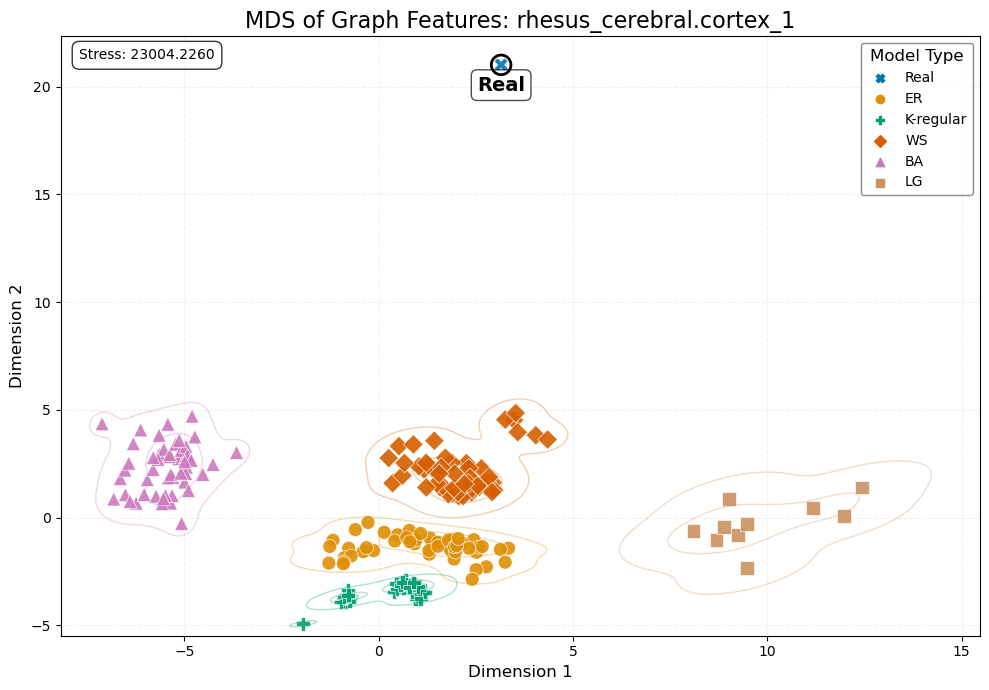

In [53]:
def plot_mds_results(X_raw, stress, graph_name="graph", figsize=(12, 10)):
    """
    Create a publication-quality MDS plot
    
    Parameters:
    -----------
    X_raw : pandas DataFrame
        DataFrame with MDS components and model information
    stress : float
        The stress value of the MDS (goodness of fit)
    graph_name : str, default="graph"
        Name of the graph to display in the title
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    # Create a color palette mapping with distinct colors
    palette = sns.color_palette("colorblind")
    model_types = X_raw['model'].unique()
    color_dict = {model: palette[i % len(palette)] for i, model in enumerate(model_types)}
    
    # Define markers for different model types
    markers = {'Real': 'X', 'ER': 'o', 'K-regular': 'P', 'WS': 'D', 'BA': '^', 'LG': 's'}
    model_markers = {model: markers.get(model, 'o') for model in model_types}
    
    # Plot density contours for each model family
    for model in model_types:
        if model == 'Real':  # Skip density for real graph
            continue
        subset = X_raw[X_raw['model'] == model]
        if len(subset) > 1:  # Only plot KDE if we have multiple points
            try:
                sns.kdeplot(
                    x=subset['PC1'], y=subset['PC2'],
                    color=color_dict[model],
                    levels=3, linewidths=1, alpha=0.3,
                    ax=ax
                )
            except Exception:
                # If KDE fails, just continue without the density plot
                pass
    
    # Scatter plot with enhanced aesthetics
    scatter = sns.scatterplot(
        data=X_raw, x='PC1', y='PC2',
        hue='model', style='model',
        s=100, edgecolor='white', linewidth=0.5,
        palette=color_dict, alpha=0.9, ax=ax,
        legend='full',
        markers=model_markers
    )
    
    # Highlight the real graph
    real_data = X_raw[X_raw['model'] == 'Real']
    if not real_data.empty:
        for _, row in real_data.iterrows():
            plt.scatter(row['PC1'], row['PC2'], s=200, facecolors='none', edgecolors='black', linewidth=2, zorder=10)
            plt.text(row['PC1'], row['PC2'] - 0.5, 'Real', fontsize=14, weight='bold', 
                    color='black', ha='center', va='top',
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    # Add plot decorations
    plt.title(f'MDS of Graph Features: {graph_name}', fontsize=16)
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    
    # Add stress value annotation
    plt.annotate(f'Stress: {stress:.4f}', xy=(0.02, 0.98), xycoords='axes fraction', 
                 fontsize=10, ha='left', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    plt.grid(True, alpha=0.2, linestyle='--')
    
    # Create legend with better positioning
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles, labels,
        title='Model Type', 
        title_fontsize=12,
        fontsize=10,
        loc='upper right',
        frameon=True,
        framealpha=0.9,
        edgecolor='gray'
    )
    
    plt.tight_layout()
    return plt

plot_mds = plot_mds_results(X_raw_mds, stress, connectome_file_name, figsize=(10, 7))
plot_mds.savefig(f'imgs/{connectome_file_name}_mds_plot.png', dpi=100, bbox_inches='tight')
plot_mds.show()

## UMAP

In [43]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap

def perform_umap_analysis(df_features, feature_columns, n_components=2, n_neighbors=15, min_dist=0.1, random_state=42):
    """
    Perform UMAP (Uniform Manifold Approximation and Projection) analysis on graph features
    
    Parameters:
    -----------
    df_features : pandas DataFrame
        DataFrame containing features and model information
    feature_columns : list
        List of column names to use as features
    n_components : int, default=2
        Number of dimensions to project onto
    n_neighbors : int, default=15
        Number of neighbors to consider for each point
    min_dist : float, default=0.1
        Minimum distance between points in the embedding
    random_state : int, default=42
        Random seed for reproducibility
        
    Returns:
    --------
    X_raw : pandas DataFrame
        Original dataframe with UMAP components added
    umap_params : dict
        Dictionary containing UMAP parameters for reference
    """
    # Remove the RGG model if it exists
    X_raw = df_features[df_features['model'] != 'RGG'] if 'RGG' in df_features['model'].unique() else df_features
    
    # Get feature columns
    X = X_raw[feature_columns].copy()
    X = X.fillna(X.mean())
    
    # Standardize the features before applying UMAP
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)
    
    # Apply UMAP to reduce the dimensionality
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    X_umap = reducer.fit_transform(X_scaled)
    
    # Add UMAP components to the original dataframe
    X_raw = X_raw.copy()
    for i in range(n_components):
        X_raw[f'PC{i+1}'] = X_umap[:, i]  # Using PC naming for compatibility with plotting function
    
    # Store UMAP parameters
    umap_params = {
        'n_neighbors': n_neighbors,
        'min_dist': min_dist
    }
    
    return X_raw, umap_params

In [44]:
def plot_umap_results(X_raw, umap_params, graph_name="graph", figsize=(12, 10)):
    """
    Create a publication-quality UMAP plot
    
    Parameters:
    -----------
    X_raw : pandas DataFrame
        DataFrame with UMAP components and model information
    umap_params : dict
        Dictionary containing UMAP parameters
    graph_name : str, default="graph"
        Name of the graph to display in the title
    figsize : tuple, default=(12, 10)
        Figure size
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    # Create a color palette mapping with distinct colors
    palette = sns.color_palette("colorblind")
    model_types = X_raw['model'].unique()
    color_dict = {model: palette[i % len(palette)] for i, model in enumerate(model_types)}
    
    # Define markers for different model types
    markers = {'Real': 'X', 'ER': 'o', 'K-regular': 'P', 'WS': 'D', 'BA': '^', 'LG': 's'}
    model_markers = {model: markers.get(model, 'o') for model in model_types}
    
    # Plot density contours for each model family
    for model in model_types:
        if model == 'Real':  # Skip density for real graph
            continue
        subset = X_raw[X_raw['model'] == model]
        if len(subset) > 1:  # Only plot KDE if we have multiple points
            try:
                sns.kdeplot(
                    x=subset['PC1'], y=subset['PC2'],
                    color=color_dict[model],
                    levels=3, linewidths=1, alpha=0.3,
                    ax=ax
                )
            except Exception:
                # If KDE fails, just continue without the density plot
                pass
    
    # Scatter plot with enhanced aesthetics
    scatter = sns.scatterplot(
        data=X_raw, x='PC1', y='PC2',
        hue='model', style='model',
        s=100, edgecolor='white', linewidth=0.5,
        palette=color_dict, alpha=0.9, ax=ax,
        legend='full',
        markers=model_markers
    )
    
    # Highlight the real graph
    real_data = X_raw[X_raw['model'] == 'Real']
    if not real_data.empty:
        for _, row in real_data.iterrows():
            plt.scatter(row['PC1'], row['PC2'], s=200, facecolors='none', edgecolors='black', linewidth=2, zorder=10)
            plt.text(row['PC1'], row['PC2'] - 0.5, 'Real', fontsize=14, weight='bold', 
                    color='black', ha='center', va='top',
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    # Add plot decorations
    plt.title(f'UMAP of Graph Features: {graph_name}', fontsize=16)
    plt.xlabel('UMAP Dimension 1', fontsize=12)
    plt.ylabel('UMAP Dimension 2', fontsize=12)
    
    # Add UMAP parameters annotation
    param_text = f"n_neighbors: {umap_params['n_neighbors']}, min_dist: {umap_params['min_dist']}"
    plt.annotate(param_text, xy=(0.02, 0.98), xycoords='axes fraction', 
                 fontsize=10, ha='left', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    plt.grid(True, alpha=0.2, linestyle='--')
    
    # Create legend with better positioning
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles, labels,
        title='Model Type', 
        title_fontsize=12,
        fontsize=10,
        loc='upper right',
        frameon=True,
        framealpha=0.9,
        edgecolor='gray'
    )
    
    plt.tight_layout()
    return plt

In [45]:
X_raw_umap, umap_params = perform_umap_analysis(
    df_features, 
    feature_columns,
    n_neighbors=15,  # Adjust these parameters as needed
    min_dist=0.1
)

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


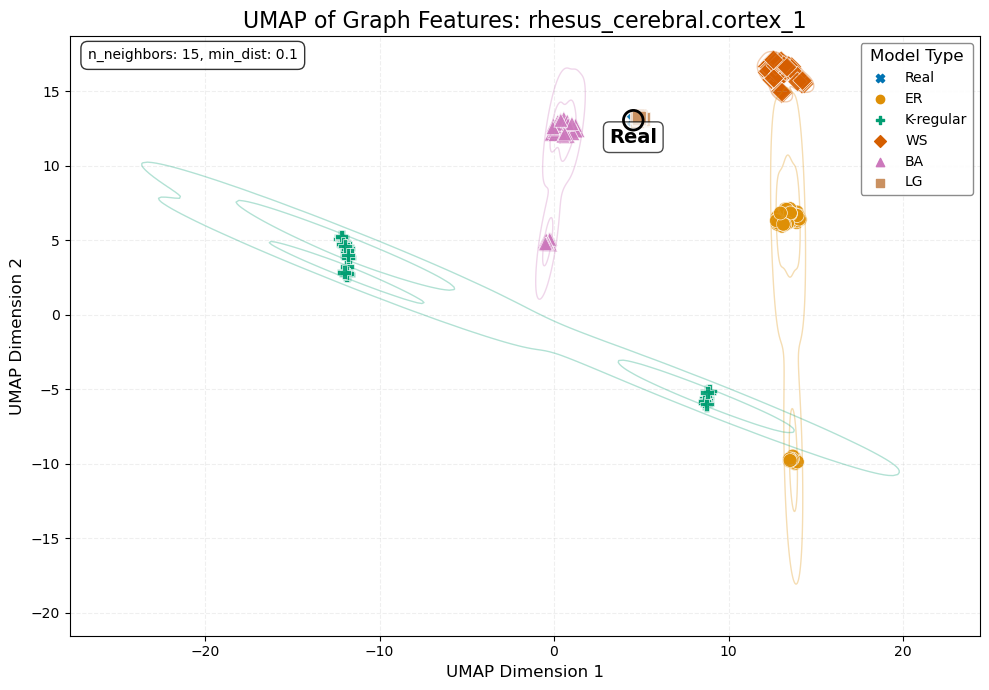

In [52]:
# Generate and save the UMAP plot
plot_umap = plot_umap_results(
    X_raw_umap, 
    umap_params, 
    connectome_file_name, 
    figsize=(10, 7)
)
plot_umap.savefig(f'imgs/{connectome_file_name}_umap_plot.png', dpi=100, bbox_inches='tight')
plot_umap.show()

## TSNE

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def perform_tsne_analysis(df_features, feature_columns, n_components=2, perplexity=30, 
                          learning_rate='auto', n_iter=1000, random_state=42):
    """
    Perform t-SNE (t-distributed Stochastic Neighbor Embedding) analysis on graph features
    
    Parameters:
    -----------
    df_features : pandas DataFrame
        DataFrame containing features and model information
    feature_columns : list
        List of column names to use as features
    n_components : int, default=2
        Number of dimensions to project onto
    perplexity : float, default=30
        Related to the number of nearest neighbors used in the manifold learning
    learning_rate : float or 'auto', default='auto'
        Learning rate for t-SNE optimization
    n_iter : int, default=1000
        Maximum number of iterations for optimization
    random_state : int, default=42
        Random seed for reproducibility
        
    Returns:
    --------
    X_raw : pandas DataFrame
        Original dataframe with t-SNE components added
    tsne_params : dict
        Dictionary containing t-SNE parameters for reference
    """
    # Remove the RGG model if it exists
    X_raw = df_features[df_features['model'] != 'RGG'] if 'RGG' in df_features['model'].unique() else df_features
    
    # Get feature columns
    X = X_raw[feature_columns].copy()
    X = X.fillna(X.mean())
    
    # Standardize the features before applying t-SNE
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)
    
    # Apply t-SNE to reduce the dimensionality
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=learning_rate,
        n_iter=n_iter,
        random_state=random_state
    )
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Add t-SNE components to the original dataframe
    X_raw = X_raw.copy()
    for i in range(n_components):
        X_raw[f'PC{i+1}'] = X_tsne[:, i]  # Using PC naming for compatibility with plotting function
    
    # Store t-SNE parameters
    tsne_params = {
        'perplexity': perplexity,
        'learning_rate': learning_rate if learning_rate != 'auto' else 'auto',
        'n_iter': n_iter,
        'kl_divergence': tsne.kl_divergence_  # Final KL divergence (lower is better)
    }
    
    return X_raw, tsne_params

In [48]:
def plot_tsne_results(X_raw, tsne_params, graph_name="graph", figsize=(12, 10)):
    """
    Create a publication-quality t-SNE plot
    
    Parameters:
    -----------
    X_raw : pandas DataFrame
        DataFrame with t-SNE components and model information
    tsne_params : dict
        Dictionary containing t-SNE parameters
    graph_name : str, default="graph"
        Name of the graph to display in the title
    figsize : tuple, default=(12, 10)
        Figure size
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    # Create a color palette mapping with distinct colors
    palette = sns.color_palette("colorblind")
    model_types = X_raw['model'].unique()
    color_dict = {model: palette[i % len(palette)] for i, model in enumerate(model_types)}
    
    # Define markers for different model types
    markers = {'Real': 'X', 'ER': 'o', 'K-regular': 'P', 'WS': 'D', 'BA': '^', 'LG': 's'}
    model_markers = {model: markers.get(model, 'o') for model in model_types}
    
    # Plot density contours for each model family
    for model in model_types:
        if model == 'Real':  # Skip density for real graph
            continue
        subset = X_raw[X_raw['model'] == model]
        if len(subset) > 1:  # Only plot KDE if we have multiple points
            try:
                sns.kdeplot(
                    x=subset['PC1'], y=subset['PC2'],
                    color=color_dict[model],
                    levels=3, linewidths=1, alpha=0.3,
                    ax=ax
                )
            except Exception:
                # If KDE fails, just continue without the density plot
                pass
    
    # Scatter plot with enhanced aesthetics
    scatter = sns.scatterplot(
        data=X_raw, x='PC1', y='PC2',
        hue='model', style='model',
        s=100, edgecolor='white', linewidth=0.5,
        palette=color_dict, alpha=0.9, ax=ax,
        legend='full',
        markers=model_markers
    )
    
    # Highlight the real graph
    real_data = X_raw[X_raw['model'] == 'Real']
    if not real_data.empty:
        for _, row in real_data.iterrows():
            plt.scatter(row['PC1'], row['PC2'], s=200, facecolors='none', edgecolors='black', linewidth=2, zorder=10)
            plt.text(row['PC1'], row['PC2'] - 0.5, 'Real', fontsize=14, weight='bold', 
                    color='black', ha='center', va='top',
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    # Add plot decorations
    plt.title(f't-SNE of Graph Features: {graph_name}', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Add t-SNE parameters annotation
    lr_str = str(tsne_params['learning_rate'])
    param_text = f"perplexity: {tsne_params['perplexity']}, learning_rate: {lr_str}"
    kl_text = f"KL divergence: {tsne_params['kl_divergence']:.4f}"
    
    plt.annotate(param_text, xy=(0.02, 0.98), xycoords='axes fraction', 
                 fontsize=10, ha='left', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    plt.annotate(kl_text, xy=(0.02, 0.93), xycoords='axes fraction', 
                 fontsize=10, ha='left', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    plt.grid(True, alpha=0.2, linestyle='--')
    
    # Create legend with better positioning
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles, labels,
        title='Model Type', 
        title_fontsize=12,
        fontsize=10,
        loc='upper right',
        frameon=True,
        framealpha=0.9,
        edgecolor='gray'
    )
    
    plt.tight_layout()
    return plt

In [49]:
# Perform t-SNE analysis
X_raw_tsne, tsne_params = perform_tsne_analysis(
    df_features, 
    feature_columns,
    perplexity=30,  # Adjust these parameters as needed
    n_iter=1000
)

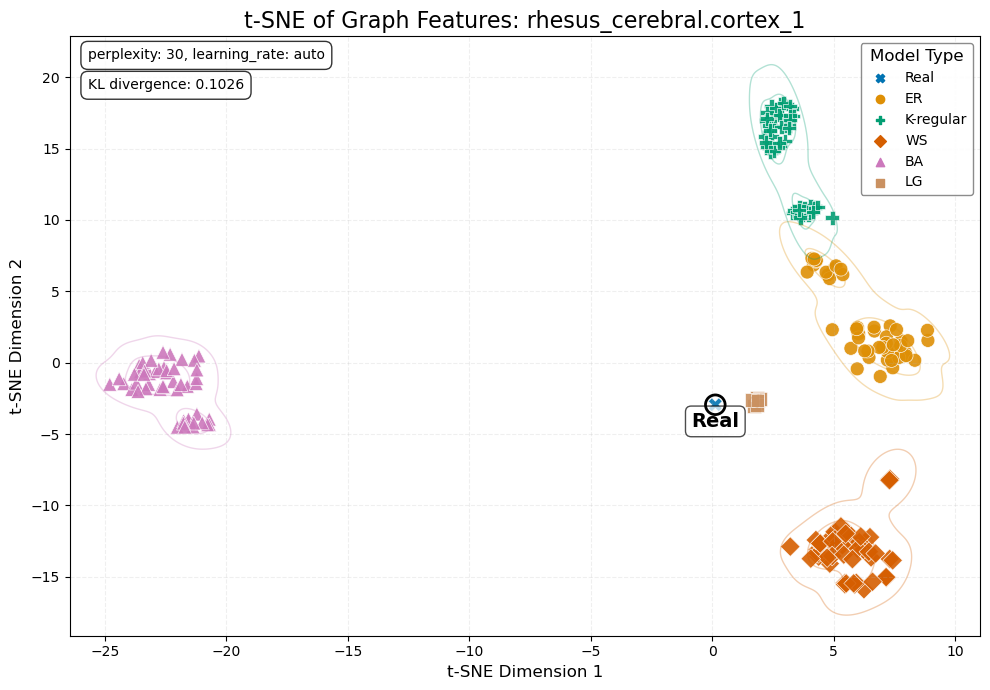

In [51]:
# Generate and save the t-SNE plot
plot_tsne = plot_tsne_results(
    X_raw_tsne, 
    tsne_params, 
    connectome_file_name, 
    figsize=(10, 7)
)
plot_tsne.savefig(f'imgs/{connectome_file_name}_tsne_plot.png', dpi=100, bbox_inches='tight')
plot_tsne.show()